In [1]:
%matplotlib inline
from matplotlib import style
style.use('fivethirtyeight')
import matplotlib.pyplot as plt

In [2]:
import numpy as np
import pandas as pd

In [3]:
import datetime as dt
from dateutil.relativedelta import relativedelta as rd

# Reflect Tables into SQLAlchemy ORM

In [4]:
# Python SQL toolkit and Object Relational Mapper
import sqlalchemy
from sqlalchemy.ext.automap import automap_base
from sqlalchemy.orm import Session
from sqlalchemy import create_engine, func

In [5]:
engine = create_engine("sqlite:///Resources/hawaii.sqlite")

In [6]:
# reflect an existing database into a new model
Base = automap_base()
# reflect the tables
Base.prepare(engine, reflect=True)

In [7]:
# We can view all of the classes that automap found
Base.classes.keys()

['measurement', 'station']

In [8]:
# Save references to each table
Measurement = Base.classes.measurement
Station = Base.classes.station

In [9]:
# Create our session (link) from Python to the DB
session = Session(engine)

### Precipitation Analysis

In [11]:
# Design a query to retrieve the last 12 months of precipitation data and plot the results
# Perform a query to retrieve the data and precipitation scores

# Calculating the last data point in the database
last_date = session.query(func.max(Measurement.date)).first()

# Calculate the date 1 year ago from the last data point in the database
date = dt.date(2017, 8, 23) - dt.timedelta(days=365)

# Perform a query to retrieve the data and precipitation scores
results = session.query(Measurement.date, Measurement.prcp).filter(Measurement.date >= date).all()

In [18]:
# Save the query results as a Pandas DataFrame and set the index to the date column
df = pd.DataFrame(results, columns=['date', 'precipitation'])
df.count()

date             2230
precipitation    2021
dtype: int64

In [19]:
# Drop row with missing information
df = df.dropna(how='any')
df.count()

date             2021
precipitation    2021
dtype: int64

In [20]:
# Sort the dataframe by date
df = df.sort_values("date")
df.head()

,date,precipitation
0,2016-08-23,0.00
1192,2016-08-23,0.02
704,2016-08-23,0.05
1881,2016-08-23,0.70
361,2016-08-23,0.15


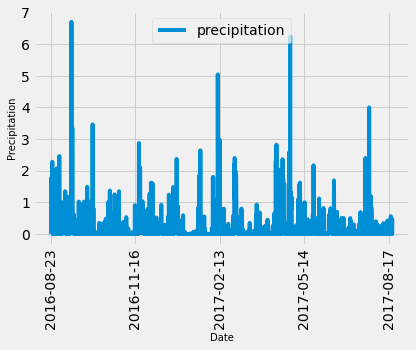

In [21]:
# Use Pandas Plotting with Matplotlib to plot the data
df.plot(x='date', y='precipitation', rot=90)
plt.xticks(rotation=90)
plt.ylabel("Precipitation", fontsize=10)
plt.xlabel("Date", fontsize=10)
plt.legend(loc='upper center')
plt.savefig("PrecipitationAnalysis.png")
plt.show()

In [22]:
# Use Pandas to calcualte the summary statistics for the precipitation data
df.describe()

,precipitation
count,2021.000000
mean,0.177279
std,0.461190
min,0.000000
25%,0.000000
50%,0.020000
75%,0.130000
max,6.700000


### Station Analysis

In [23]:
# Design a query to show how many stations are available in this dataset?
# Design a query to show how many stations are available in this dataset?
session.query(Station.name).all()

#Query to count the stations available in the database
# session.query(Station.station).count()

[('WAIKIKI 717.2, HI US'),
 ('KANEOHE 838.1, HI US'),
 ('KUALOA RANCH HEADQUARTERS 886.9, HI US'),
 ('PEARL CITY, HI US'),
 ('UPPER WAHIAWA 874.3, HI US'),
 ('WAIMANALO EXPERIMENTAL FARM, HI US'),
 ('WAIHEE 837.5, HI US'),
 ('HONOLULU OBSERVATORY 702.2, HI US'),
 ('MANOA LYON ARBO 785.2, HI US')]

In [24]:
#What are the most active stations? (i.e. what stations have the most rows)? 
#List the stations and the counts in descending order.
session.query(Measurement.station, func.count(Measurement.station)).\
group_by(Measurement.station).\
order_by(func.count(Measurement.station).desc()).all()

[('USC00519281', 2772),
 ('USC00519397', 2724),
 ('USC00513117', 2709),
 ('USC00519523', 2669),
 ('USC00516128', 2612),
 ('USC00514830', 2202),
 ('USC00511918', 1979),
 ('USC00517948', 1372),
 ('USC00518838', 511)]

In [25]:
# Using the station id from the previous query, calculate the lowest temperature recorded, 
# highest temperature recorded, and average temperature of the most active station?
session.query(func.min(Measurement.tobs), func.max(Measurement.tobs), func.avg(Measurement.tobs)).\
filter(Measurement.station == 'USC00519281').all()

[(54.0, 85.0, 71.66378066378067)]

Text(0.5, -1.340000000000014, 'Temperature')

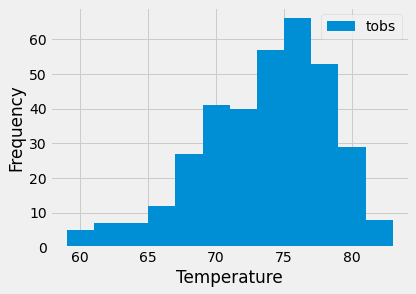

In [26]:
date = dt.date(2017, 8, 23) - dt.timedelta(days=365)

results = session.query(Measurement.tobs).\
filter(Measurement.station == 'USC00519281').\
filter(Measurement.date >= date).all()

df = pd.DataFrame(results, columns=['tobs'])
df.plot.hist(bins=12)
plt.tight_layout()
plt.xlabel("Temperature")

#  Bonus Challenge Assignment: Temperature Analysis II

In [29]:
# This function called `calc_temps` will accept start date and end date in the format '%Y-%m-%d' 
# and return the minimum, maximum, and average temperatures for that range of dates
def calc_temps(start_date, end_date):
    """TMIN, TAVG, and TMAX for a list of dates.
    
    Args:
        start_date (string): A date string in the format %Y-%m-%d
        end_date (string): A date string in the format %Y-%m-%d
        
    Returns:
        TMIN, TAVE, and TMAX
    """
    
    return session.query(func.min(Measurement.tobs), func.avg(Measurement.tobs), func.max(Measurement.tobs)).\
        filter(Measurement.date >= start_date).filter(Measurement.date <= end_date).all()

# For example
print(calc_temps('2012-02-28', '2012-03-05'))

[(62.0, 69.57142857142857, 74.0)]


In [31]:
# Use the function `calc_temps` to calculate the tmin, tavg, and tmax 
# for a previous year in the data set
import datetime as dt

start_date = dt.date(2017, , 5)
end_date = dt.date(2017, 5, 20)

tmin, tavg, tmax = list(np.ravel(calc_temps(start_date, end_date)))
print(tmin, tavg, tmax)

66.0 74.98876404494382 80.0


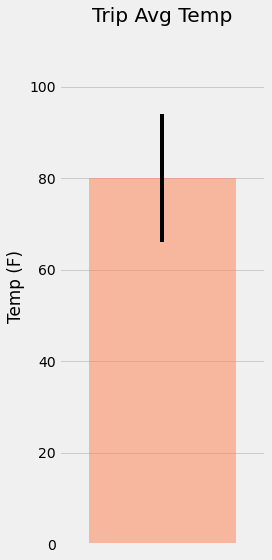

In [32]:
# Plot the results from your previous query as a bar chart. 
# Use "Trip Avg Temp" as your Title
# Use the average temperature for bar height (y value)
# Use the peak-to-peak (tmax-tmin) value as the y error bar (yerr)
fig, ax = plt.subplots(figsize=plt.figaspect(2.))
xpos = 1
yerr = tmax-tmin

bar = ax.bar(xpos, tmax, yerr=yerr, alpha=0.5, color='coral', align="center")
ax.set(xticks=range(xpos), xticklabels="a", title="Trip Avg Temp", ylabel="Temp (F)")
ax.margins(.2, .2)
# fig.autofmt_xdate()
fig.tight_layout()

# Daily Rainfall Average

In [34]:
# Calculate the total amount of rainfall per weather station for your trip dates using the previous year's 
# matching dates.
# Sort this in descending order by precipitation amount and list the station, name, latitude, longitude, and elevation

start_date = '2017-05-05'
end_date = '2017-05-20'

sel = [Station.station, Station.name, Station.latitude, 
       Station.longitude, Station.elevation, func.sum(Measurement.prcp)]

results = session.query(*sel).\
    filter(Measurement.station == Station.station).\
    filter(Measurement.date >= start_date).\
    filter(Measurement.date <= end_date).\
    group_by(Station.name).order_by(func.sum(Measurement.prcp).desc()).all()
print(results)

[('USC00516128', 'MANOA LYON ARBO 785.2, HI US', 21.3331, -157.8025, 152.4, 4.62), ('USC00519281', 'WAIHEE 837.5, HI US', 21.45167, -157.84888999999998, 32.9, 3.3099999999999996), ('USC00513117', 'KANEOHE 838.1, HI US', 21.4234, -157.8015, 14.6, 2.34), ('USC00514830', 'KUALOA RANCH HEADQUARTERS 886.9, HI US', 21.5213, -157.8374, 7.0, 2.0399999999999996), ('USC00519523', 'WAIMANALO EXPERIMENTAL FARM, HI US', 21.33556, -157.71139, 19.5, 1.26), ('USC00519397', 'WAIKIKI 717.2, HI US', 21.2716, -157.8168, 3.0, 0.08)]


In [35]:
# Use this function to calculate the daily normals 
# (i.e. the averages for tmin, tmax, and tavg for all historic data matching a specific month and day)

def daily_normals(date):
    """Daily Normals.
    
    Args:
        date (str): A date string in the format '%m-%d'
        
    Returns:
        A list of tuples containing the daily normals, tmin, tavg, and tmax
    
    """
    
    sel = [func.min(Measurement.tobs), func.avg(Measurement.tobs), func.max(Measurement.tobs)]
    return session.query(*sel).filter(func.strftime("%m-%d", Measurement.date) == date).all()

# For example
daily_normals("01-01")

[(62.0, 69.15384615384616, 77.0)]

In [36]:
# calculate the daily normals for your August trip
# push each tuple of calculations into a list called `normals`

# Set the start and end date of the trip
start_date = '2017-05-05'
end_date = '2017-05-20'

# Use the start and end date to create a range of dates
range_dates = pd.date_range(start_date, end_date)

# Strip off the year and save a list of strings in the format %m-%d
new_list = range_dates.strftime('%m-%d')

# Use the `daily_normals` function to calculate the normals for each date string 
# and append the results to a list called `normals`.
normals = []
for date in new_list:
    normals.append(*daily_normals(date))
    
normals

[(67.0, 73.39655172413794, 79.0),
 (66.0, 73.14035087719299, 80.0),
 (64.0, 71.78846153846153, 79.0),
 (65.0, 72.18867924528301, 80.0),
 (67.0, 72.9322033898305, 79.0),
 (64.0, 73.3157894736842, 78.0),
 (65.0, 73.61111111111111, 79.0),
 (65.0, 73.13793103448276, 79.0),
 (67.0, 73.14285714285714, 79.0),
 (63.0, 73.89285714285714, 80.0),
 (63.0, 73.69090909090909, 79.0),
 (68.0, 74.37931034482759, 80.0),
 (68.0, 74.45, 79.0),
 (68.0, 74.10714285714286, 82.0),
 (65.0, 73.80701754385964, 79.0),
 (68.0, 73.89655172413794, 79.0)]

In [39]:
# Load the previous query results into a Pandas DataFrame and add the `trip_dates` range as the `date` index
df = pd.DataFrame(normals, columns=['tmin', 'tavg', 'tmax'])
df['date'] = range_dates
df.set_index(['date'],inplace=True)
df

,tmin,tavg,tmax
date,,,
2017-05-05,67.0,73.396552,79.0
2017-05-06,66.0,73.140351,80.0
2017-05-07,64.0,71.788462,79.0
2017-05-08,65.0,72.188679,80.0
2017-05-09,67.0,72.932203,79.0
2017-05-10,64.0,73.315789,78.0
2017-05-11,65.0,73.611111,79.0
2017-05-12,65.0,73.137931,79.0
2017-05-13,67.0,73.142857,79.0


Text(9.310000000000002, 0.5, 'Rainfall')

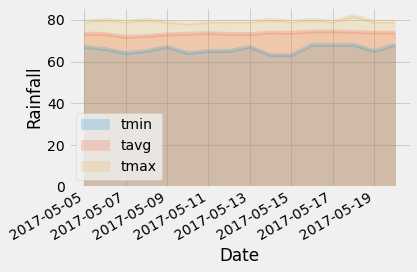

In [40]:
# Plot the daily normals as an area plot with `stacked=False`
df.plot(kind='area', stacked=False, x_compat=True, alpha=.2)
plt.tight_layout()
plt.xlabel("Date")
plt.ylabel("Rainfall")

In [41]:
session.close()